Term: YAI 2021 summer session

Team Member: Dongha Kim, Jeongeun Lee, Junho Lee, Suyeong Choi.

# **ResNet: Training a Classifier**

## **What is CIFAR10?**

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

Link: https://www.cs.toronto.edu/~kriz/cifar.html


## **Mission**

In the lecture, you have seen how to define neural networks, compute loss and make updates to the weights of the network. In this task, you will classify CIFAR10 images by using a ResNet.

We will do the following steps in order:

1. Load and normalize the CIFAR10 training and test datasets using torchvision
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

You can set the number of layers freely when constructing a model. Share the results among your team members.

# Prepare library and dataset

In [1]:
# Import library
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from extensions.easyrun import Trainer, runtime_info, dataset_info  # type: ignore

# Configure Runtime
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Print Runtime Information
print(runtime_info())

<Runtime Information>
OS version: 		Windows-10-10.0.19041-SP0
Python version:		3.8.8 [MSC v.1916 64 bit (AMD64)]
Torch version:		1.8.1
Torch device:		cuda


In [2]:
# CIFAR-10 Dataset
train_dataset = datasets.CIFAR10(
    root='data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.CIFAR10(
    root='data', train=False, transform=transforms.ToTensor())
# train_dataset, val_dataset = torch.utils.data.random_split(
#     train_dataset, [40000, 10000])  # split - 4:1

# Summarize Dataset
print(dataset_info(train=train_dataset, test=test_dataset, loader=False))

Files already downloaded and verified
<Dataset Information>
Train Dataset: 		50000
Test Dataset: 		10000


# Preprocess CIFAR-10

## Normalize

In [3]:
# Normalize dataset

def make_normalize(dataset):

    mean_rgb, std_rgb = [], []
    for x, _ in dataset:
        x = x.numpy()
        mean_rgb.append(np.mean(x, axis=(1, 2)))
        std_rgb.append(np.std(x, axis=(1, 2)))

    transform_mean = tuple((np.mean([m[i] for m in mean_rgb]) for i in range(3)))
    transform_std = tuple((np.std([s[i] for s in std_rgb]) for i in range(3)))

    print(f"mean: {transform_mean}, std: {transform_std}")
    return transforms.Normalize(mean=transform_mean, std=transform_std)


normalizer = make_normalize(train_dataset)

mean: (0.49139965, 0.48215845, 0.4465309), std: (0.060528398, 0.061124973, 0.06764512)


## Data Augmentation

In [4]:
train_transforms = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    normalizer,
])

test_transforms = transforms.Compose([
    transforms.Pad(4),
    transforms.ToTensor(),
    normalizer,
])

## Apply Preprocessing

In [5]:
# Apply
train_dataset.transform = train_transforms
test_dataset.transform = test_transforms

# Make Data Loader
train_loader = torch.utils.data.DataLoader(  # type: ignore
    dataset=train_dataset, batch_size=250, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(  # type: ignore
    dataset=test_dataset, batch_size=250, shuffle=False, num_workers=2)

# Summarize Data Loader
print(dataset_info(train=train_loader, test=test_loader, loader=True))

<DataLoader Information>
Train Batch: 		200
Test Batch: 		40


# Build Resnet

## 3x3 Convolution Layer

In [6]:
# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_channels, out_channels,
        kernel_size=(3, 3), padding=(1, 1), groups=1, bias=False, stride=stride,
    )

## Residual Block

In [7]:
# Residual block
class ResidualBlock(nn.Module):

    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.residual_function = nn.Sequential(
            conv3x3(in_channels, out_channels, stride),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            conv3x3(out_channels, out_channels),
            nn.BatchNorm2d(out_channels)
        )
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.residual_function(x)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out


## Resnet

In [8]:
# ResNet
class ResNet(nn.Module):

    def __init__(self, block, layers, in_channels=64, num_classes=10):

        super().__init__()

        self.in_channels = in_channels
        self.block = block

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(
                3, self.in_channels,
                kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
            ),
            nn.BatchNorm2d(self.in_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            *[
                self.make_layer(2 ** (6 + i), layers[num_blocks], stride=2 if i else 1)
                for i, num_blocks in enumerate(layers)
            ],
            nn.AdaptiveAvgPool2d((1, 1)),
        )
        self.fc = nn.Linear(2 ** (5 + len(layers)) * block.expansion, num_classes)

        # Weight Initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def make_layer(self, out_channels, layers, stride=1):

        block = self.block
        first_in_channels = self.in_channels

        downsample = None

        if stride != 1 or first_in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels, out_channels * block.expansion,
                    kernel_size=(1, 1), stride=(stride, stride), bias=False
                ),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        # configure the number of next in-channel
        self.in_channels = out_channels * block.expansion

        return nn.Sequential(
            block(first_in_channels, out_channels, stride, downsample),
            *[block(self.in_channels, out_channels)] * (layers - 1)
        )

    def forward(self, x):
        out = self.feature_extractor(x)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out


# Train and Test

## Set Hyper-parameters and Instantiate Resnet

In [9]:
# Set hyper-parameters and prepare train objects
num_epochs = 120
model = ResNet(ResidualBlock, [2, 2, 2])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=1 / 3)


## Run

Trainer Source:
* https://github.com/kdha0727/Easyrun-Pytorch/blob/master/easyrun.py

In [10]:
# Train and Test
with Trainer(
        model, 'CrossEntropyLoss', optimizer, num_epochs,
        train_iter=train_loader, test_iter=test_loader, val_iter=test_loader,
        step_task=lr_scheduler.step, verbose=True, timer=True, log_interval=1,
) as trainer:
    trainer.to(device)
    train_result = trainer.run()
    test_loss, test_accuracy = trainer.test()

# Save the model checkpoint
torch.save(model.state_dict(), 'yai_4th_week.pt')


<Start Learning> 				Total 120 epochs

Epoch 1
[Train]	 Average loss: 1.57185, 		Total accuracy: 41.71%  
[Eval]	 Average loss: 1.36001, 		Total accuracy: 49.40% 

Epoch 2
[Train]	 Average loss: 1.16825, 		Total accuracy: 57.57%  
[Eval]	 Average loss: 1.11561, 		Total accuracy: 60.61% 

Epoch 3
[Train]	 Average loss: 1.00435, 		Total accuracy: 64.24%  
[Eval]	 Average loss: 1.08626, 		Total accuracy: 62.88% 

Epoch 4
[Train]	 Average loss: 0.89805, 		Total accuracy: 68.04%  
[Eval]	 Average loss: 0.86803, 		Total accuracy: 69.23% 

Epoch 5
[Train]	 Average loss: 0.81829, 		Total accuracy: 71.24%  
[Eval]	 Average loss: 0.94382, 		Total accuracy: 67.93% 

(...)

Epoch 116
[Train]	 Average loss: 0.24767, 		Total accuracy: 91.31%  
[Eval]	 Average loss: 0.37794, 		Total accuracy: 88.26% 

Epoch 117
[Train]	 Average loss: 0.25220, 		Total accuracy: 91.14%  
[Eval]	 Average loss: 0.37795, 		Total accuracy: 88.27% 

Epoch 118
[Train]	 Average loss: 0.25395, 		Total accuracy: 91.09%  
[Eval

## Visualize Training Process

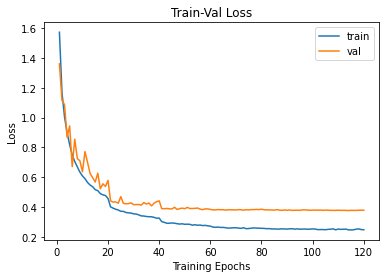

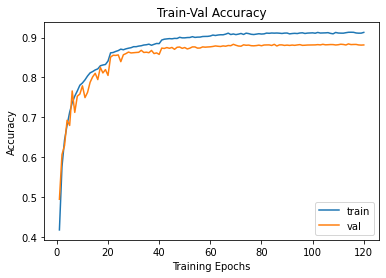

In [11]:
train_result = np.array(train_result)

# Loss Plot
plt.title("Train-Val Loss")
plt.plot(range(1, num_epochs + 1), train_result[:, 0], label="train")
plt.plot(range(1, num_epochs + 1), train_result[:, 2], label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# Accuracy Plot
plt.title("Train-Val Accuracy")
plt.plot(range(1, num_epochs + 1), train_result[:, 1], label="train")
plt.plot(range(1, num_epochs + 1), train_result[:, 3], label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()